In [1]:
from functools import partial

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import init
import numpy as np

In [67]:
class FixedSlotAttentionMultiHeadProb(torch.nn.Module):
    """Implementation of Probabalistic Slot Attention from Identifiable Object-Centric Representation Learning
    via Probabilistic Slot Attention by Kori et al. 2024."""
    def __init__(self, num_slots: int, slot_dim: int, input_dim: int, num_iterations: int, num_heads: int = 4, hidden_dim: int = 256, temperature: float = 1, probabalistic: bool = False):
        super(FixedSlotAttentionMultiHeadProb, self).__init__()
        self.num_slots = num_slots
        self.num_iterations = num_iterations
        self.slot_dim = slot_dim
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.scale = (slot_dim // num_heads) ** -0.5
        self.temperature = temperature
        self.probabalistic = probabalistic
        self.eps = 1e-5

        self.slots_mu = nn.Parameter(torch.zeros(1, self.num_slots, slot_dim))
        init.xavier_uniform_(self.slots_mu)
        self.mu_scale = nn.Parameter(torch.zeros(1, self.num_slots, slot_dim))
        init.xavier_uniform_(self.mu_scale)
        self.slots_logsigma = nn.Parameter(torch.ones(1, self.num_heads, 1, slot_dim // num_heads))
        # init.xavier_uniform_(self.slots_logsigma)

        # learnable weights
        self.mixing_coeffs = nn.Parameter(1/self.num_slots * torch.ones(1, self.num_slots), requires_grad=False)  # shape (1, K)
        self.to_keys = nn.Parameter(torch.rand(self.input_dim, self.slot_dim))      # from inputs
        self.to_queries = nn.Parameter(torch.rand(self.num_slots, self.slot_dim, self.slot_dim))   # from slots
        self.to_values = nn.Parameter(torch.rand(self.input_dim, self.slot_dim))    # from inputs

        self.gru = nn.GRUCell(slot_dim, slot_dim)

        hidden_dim = max(slot_dim, hidden_dim)

        self.mlp = nn.Sequential(
            nn.Linear(slot_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, slot_dim)
        )

        self.layer_norm_inputs = nn.LayerNorm(input_dim)
        self.layer_norm_slots = nn.LayerNorm(slot_dim)
        self.layer_norm_pre_ff = nn.LayerNorm(slot_dim)

    def gaussian_log_prob(self, x: torch.Tensor, loc: torch.Tensor, var: torch.Tensor):
        var = var.clamp(min=1e-5)  # for stability
        return (
            # -0.5 * np.log(2 * np.pi)
            -0.5 * torch.log(var)
            - 0.5 * (x - loc) ** 2 / var
        )
    
    def forward(self, embeddings: torch.Tensor):
        """Slot Attention """
        B, N, D = embeddings.shape
        # 1) initialise the slots 
        # if self.training:
        #     sigma = self.train_sigma.exp().expand(B, self.num_slots, -1)
        #     slots = self.train_mu + self.train_sigma.exp() * torch.randn(
        #         B, self.num_slots, self.slot_dim, device=embeddings.device
        #     )
        # else:
        mu = self.slots_mu.repeat(B, 1, 1)
        slots = mu + self.mu_scale.exp() * torch.randn(mu.shape, device=embeddings.device)

        sigma = self.slots_logsigma.repeat(B, 1, self.num_slots, 1)

        mixing_coeffs = self.mixing_coeffs.expand(B, -1).unsqueeze(2)  # shape (B, K, 1)
        
        embeddings = self.layer_norm_inputs(embeddings)
        keys = torch.einsum("bne,ed->bnd", embeddings, self.to_keys).view(B, N, self.num_heads, self.slot_dim // self.num_heads) # shape (B, N, H, D/H)
        values = torch.einsum("bne,ed->bnd", embeddings, self.to_values).view(B, N, self.num_heads, self.slot_dim // self.num_heads) # shape (B, K, N, H, D/H)
        
        for _ in range(self.num_iterations):
            slots_prev = slots
            slots = self.layer_norm_slots(slots) # shape (B, K, D)
            
            
            # attention = mixture coefficients * likelihood of gaussian / sum of mixture coefficients * likelihood of gaussian
            # Bishop Pattern Recognition and Machine Learning page 78
            # find likelihood of keys under normal given by queries and sigma
            queries = torch.einsum('bkd,kdd->bkd', slots, self.to_queries).view(B, self.num_slots, self.num_heads, self.slot_dim // self.num_heads).unsqueeze(2)  # shape (B, K, H, 1, D/H)
            sigma = sigma.view(B, self.num_slots, self.num_heads, self.slot_dim // self.num_heads).unsqueeze(2) # shape (B, K, H, 1, D/H)

    	    # sigma shape B, K, D, query shape B, K, H, D/H, keys shape B, K, N, H, D/H
            exponent = -0.5 * (keys.unsqueeze(1) - queries)**2 / (sigma**2)     # shape (B, K, N)
            log_pi = -0.5 * D * torch.log(torch.tensor(2*torch.pi))                                     # shape (1)
            log_scale = - torch.log(torch.clamp(sigma, min=self.eps))#.unsqueeze(2)                      # shape (B, K, 1, D)
       
            gaussian_log_likelihood = torch.log(mixing_coeffs).unsqueeze(-1) + (log_pi + log_scale + exponent).sum(dim=-1) * self.scale  # shape (B, K, N)
            print(gaussian_log_likelihood.shape)
            attn = F.softmax(gaussian_log_likelihood, dim=1)                                 # shape (B, K, N, H)
            print(attn.shape)
            attn_vis = attn.sum(-1)

            Nk = attn.sum(dim=2, keepdim=True)  # shape (B, K, 1, H)
            Nk = Nk.permute(0, 1, 3, 2)  # shape (B, K, H, 1)
  
            slot_updates = torch.einsum('bknh,bnhu->bkhu', attn, values)   # shape (B, K, H, D/H)
            slot_updates = (1 / Nk) * slot_updates  # shape (B, K, H, D/H)     

            sigma = torch.sum(attn.unsqueeze(-1) * (values.unsqueeze(1) - slot_updates.unsqueeze(2))**2, dim=2) # shape (B, K, H, D/H)
            sigma = (1 / Nk) * sigma  # shape (B, K, D)
            sigma = torch.sqrt(sigma)  # shape (B, K, D)
            
            mixing_coeffs = Nk.sum(-2) / N  # update mixing coefficients
            
            # 5) GRU to update slots
            #slot_updates = slot_updates.view(B, self.num_slots, self.slot_dim)
            print(slot_updates.shape, slots_prev.shape)
            print(slot_updates.view(-1, self.slot_dim).shape, slots_prev.view(-1, self.slot_dim).shape)
            slots = self.gru(slot_updates.view(-1, self.slot_dim), slots_prev.view(-1, self.slot_dim))

            slots = slots.reshape(B, self.num_slots, self.slot_dim)
            slots = slots + self.mlp(self.layer_norm_pre_ff(slots)) # shape (B, K, D)
            
        sigma = sigma.view(B, self.num_slots, self.slot_dim)
        # sample from slotwise distributions
        slots = slots + sigma * torch.randn_like(slots)
        
        return slots, attn_vis

In [69]:
sample_embeddings = torch.randn((64, 196, 1024))   # B, N, D
slot_attention = FixedSlotAttentionMultiHeadProb(num_slots=4, num_heads=4, slot_dim=256, input_dim=1024, num_iterations=3, probabalistic=True)
slots, attn = slot_attention(sample_embeddings)

torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 196, 4, 64])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 4, 64]) torch.Size([64, 4, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 196, 4, 64])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 4, 64]) torch.Size([64, 4, 256])
torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 4, 1, 4, 64])
torch.Size([64, 196, 4, 64])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 196, 4])
torch.Size([64, 4, 4, 64]) torch.Size([64, 4, 256])
torch.Size([256, 256]) torch.Size([256, 256])


In [17]:
print(slots.shape, attn.shape)

tensor([[[ -1.9865,  -4.7517,   3.8700,  ...,   2.3450,  22.3162, -13.8800],
         [ -8.8693,  15.2051,  -5.2328,  ...,   8.4942,   5.8185,   1.0653],
         [  4.1657,  -1.4027,   9.9303,  ...,   2.5509,   2.5038,   5.0809],
         [  0.3832, -10.6470,  -9.3103,  ...,  12.9620,  -6.7498,  21.4182]],

        [[ -2.7615,   5.2972,   0.9950,  ...,   5.3752,   8.6468, -14.0466],
         [ -2.9695,   8.2313,  -2.1252,  ...,  -0.8059,  27.5942, -20.4276],
         [  7.0061,  -2.9013,   8.5858,  ...,  -2.4287,  -6.3599,  -1.9806],
         [  6.8349, -15.0775,   0.4107,  ...,   7.4028, -16.4034,   0.2614]]],
       grad_fn=<AddBackward0>) torch.Size([2, 4, 196])


In [18]:
print(torch.isnan(slots).any())

tensor(False)


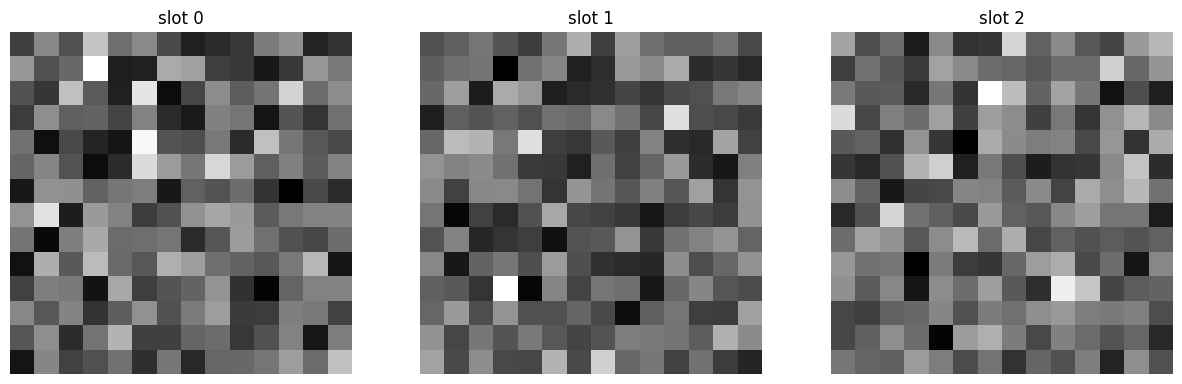

In [7]:
# plot attention matrix
import matplotlib.pyplot as plt
import matplotlib
image_num = 0 
# slot 0
attn = attn[image_num, :, :].detach().cpu()
slot_0_attn = attn[0, :]
slot_0_attn = slot_0_attn.reshape(14, 14)

f, ax = plt.subplots(1, attn.shape[0], figsize=(15, 15))

for slot in range(attn.shape[0]):
    slot_attn = attn[slot, :]
    slot_attn = slot_attn.reshape(14, 14)
    ax[slot].imshow(slot_attn, cmap=matplotlib.cm.gray)
    ax[slot].axis('off')
    ax[slot].set_title(f'slot {slot}')

In [9]:
saved_model = ViTAE.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/lightning_logs/chestxray_mae/chestxray_mae/11h1j4vq/checkpoints/epoch=0-step=377.ckpt',
    model_kwargs={
        'img_size': 224,
        'embed_dim': 1024,
        'num_channels': 1,
        'num_heads': 16,
        'depth': 18,
        'decoder_embed_dim': 512,
        'decoder_depth': 8,
        'decoder_num_heads': 16,
        'norm_layer': partial(nn.LayerNorm, eps=1e-6),
        'mlp_ratio': 4.0,
        'patch_size': 16,
        'norm_pix_loss': False,
        'mask_ratio': 0.0,
        'dropout': 0.00,
    },
    learning_rate=1e-4,
    map_location=torch.device('cuda:0'),
    )

In [10]:
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=32)

True


Loading Data: 100%|██████████| 50/50 [00:00<00:00, 24408.19it/s]


In [11]:
batch = next(iter(data.test_dataloader()))
saved_model.eval()
for param in saved_model.model.parameters():    # freeze all parameters
    param.requires_grad = False
saved_model.mask_ratio = 0.0        # do not mask patches
with torch.no_grad():
    encoded_embeddings, mask, mask_indices, num_masked_tokens = saved_model.model.encoder(batch['image'].to('cuda:0'))

In [16]:
slot_attention = FixedSlotAttention(num_slots=4, dim=1024, num_iterations=3).to('cuda:0')
slots, attn = slot_attention(encoded_embeddings[:, :196, :])

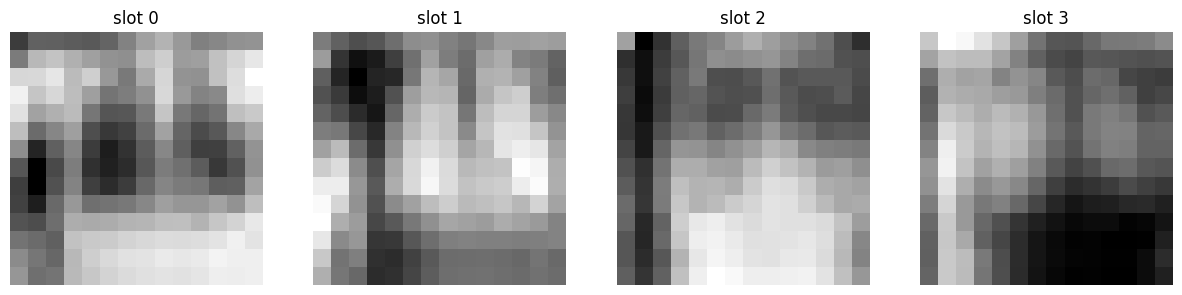

In [17]:
image_num = 0 
# slot 0
attn = attn[image_num, :, :].detach().cpu()
slot_0_attn = attn[0, :]
slot_0_attn = slot_0_attn.reshape(14, 14)

f, ax = plt.subplots(1, attn.shape[0], figsize=(15, 15))

for slot in range(attn.shape[0]):
    slot_attn = attn[slot, :]
    slot_attn = slot_attn.reshape(14, 14)
    ax[slot].imshow(slot_attn, cmap=matplotlib.cm.gray)
    ax[slot].axis('off')
    ax[slot].set_title(f'slot {slot}')